# **HOUSE PRICE PREDICTION**

Sử dụng các mô hình đã học hoặc nâng cao để áp dụng vào bài toán dự đoán giá nhà

Github: https://github.com/hoangducnhatminh/predict-house-price-advanced.git

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load data
train_data = pd.read_csv('train_official.csv', index_col='Id')
test_data = pd.read_csv('test_official.csv', index_col='Id')
train_data.head()

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.244415,-0.257308,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.621525,...,False,False,False,True,False,False,False,True,False,12.247699
2,0.547599,0.035675,0.0,0.0,0.0,0.0,0.0,0.0,2.630317,0.062576,...,False,False,False,True,False,False,False,True,False,12.109016
3,-0.072504,0.399864,0.0,0.0,-1.0,0.0,0.0,0.5,0.000000,0.580380,...,False,False,False,True,False,False,False,True,False,12.317171
4,-0.549090,0.023685,0.0,0.0,-1.0,0.0,0.0,0.5,0.000000,-1.228865,...,False,False,False,True,False,False,False,False,False,11.849405
5,0.734014,0.944281,0.0,0.0,-1.0,0.0,0.0,1.0,0.000000,0.559792,...,False,False,False,True,False,False,False,True,False,12.429220


In [3]:
# Seperate features and target variable
X_train = np.array(train_data.drop(['SalePrice'], axis=1))
y = np.array(train_data.SalePrice)

In [4]:
X_train.shape

(1458, 228)

# 1. MODELING

## Nhắc lại về hồi quy tuyến tính
**Phương trình hồi quy trên mẫu nghiên cứu:**

$y = w_0 + w_1x_1 + w_2x_2 + … + w_nx_n + ε$

Trong đó:

- $y$: biến phụ thuộc
- $x_1, x_2, x_n$: biến độc lập
- $w_0$: hằng số hồi quy
- $w_1, w_2, w_n$: hệ số hồi quy
- $ε$: phần dư

- Cần tìm w = [$w_0, w_1, ..., w_n$] sao cho tối thiểu hàm mất mát, ví dụ như hàm MSE.

<a href="https://imgbb.com/"><img src="img/MSE.png" alt="MSE" border="0"></a>

## Cách đánh giá mô hình

Trong model evaluation, thường thì ta sẽ chia toàn bộ data làm 2 tập train và test. Tuy nhiên data khá nhỏ, nên nếu chia như vậy, thì có lẽ mô hình sẽ dễ bị overfitting, do đó, ta dùng `cross-validation` để train mô hình.


Đề bài yêu cầu đánh giá mô hình bằng độ đo RMSE, tuy nhiên do target variable đã được biến đổi qua log(1 + y), nên MSE cho log(1 + y) là MSLE - Mean Squared Logarithmic Error.

In [5]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

## 1.1 REGULARIZED REGRESSIONS

### 1.1.1 Ridge

Hàm mất mát trong hồi qui Ridge sẽ có sự thay đổi so với hồi qui tuyến tính, đó là thêm Regularization Term so với hàm mất mát của hồi qui tuyến tính thông thường.

#### Regularization Term = $λ * ||w||^2$
Trong đó: 
- $λ$ là hyperparameter
- $||w||^2$ là bình phương độ lớn của các hệ số hồi quy


- Đối với `Hồi quy tuyến tính` mô hình có thể bị Overfitting nếu nó lấy luôn những w quá nhỏ.

- Tham số λ kiểm soát Regularization Term và quyết định mức độ thu nhỏ với những hệ số hồi quy, có thể hiểu Regularization Term là để quyết định có giữ hay không các w nhỏ.

- Hệ số λ lớn dẫn đến hệ số hồi quy thu nhỏ gần về 0 và kết quả là mô hình giảm độ phức tạp, λ nhỏ dẫn đến vai trò của Regularization Term ít ảnh hưởng đến hàm mất mát. Mức độ kiểm soát quá khớp của mô hình sẽ trở nên kém hơn.

Giá trị của λ thường dược lựa chọn bằng cách dùng  cross-validation (xác thực chéo), bao gồm việc fit mô hình theo nhiều subsets of data và lựa chọn λ dựa vào tập validation được cho ra tốt nhất.

In [6]:
from sklearn.linear_model import Ridge

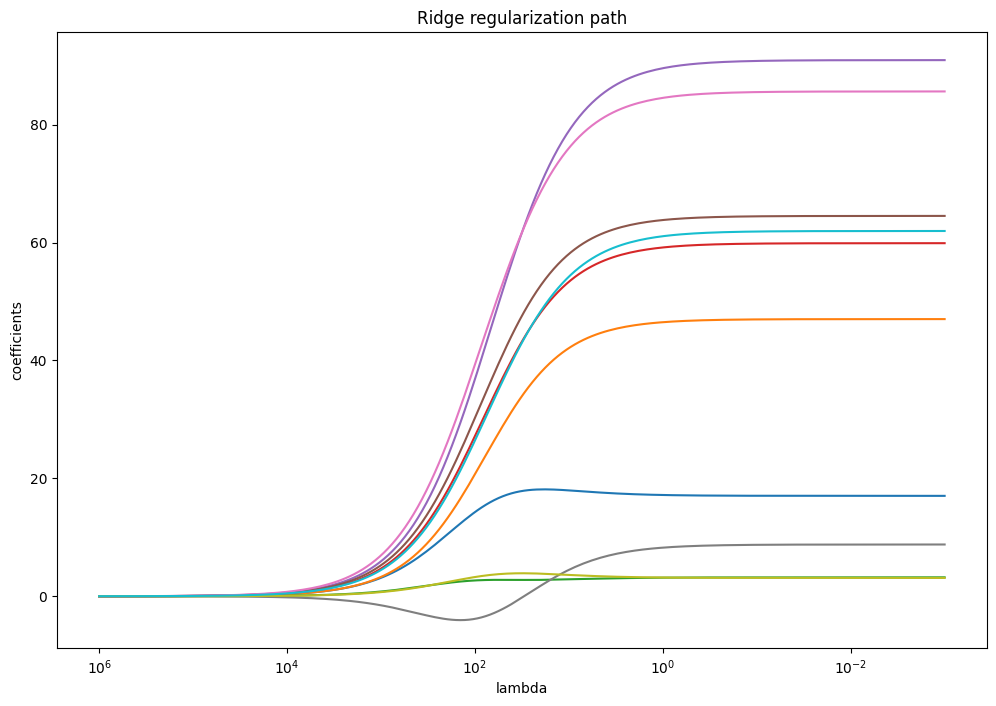

In [7]:
# Generate sample data
X_, y_ = make_regression(n_samples=100, n_features=10, noise=10, random_state=42)

# Split data into training and test sets
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Scale data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

# Fit ridge regression model with different values of lambda
n_alphas = 200
alphas = 1/np.logspace(3, -6, n_alphas)
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train_scaled, y_train_)
    coefs.append(ridge.coef_)

# Create regularization path plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.title('Ridge regularization path')
plt.axis('tight')
plt.show()

Với thuật toán regularized linear regression (Ridge), ta đi tối thiểu hàm mất mát:

<a href="https://imgbb.com/"><img src="img/Loss_Ridge.png" alt="Loss_Ridge" border="0"></a>

Nhóm sẽ tìm $\lambda$ tốt nhất cho smallest **RMSLE** thông qua phương pháp cross-validation:

Best lambda: 13.8
RMSLE: 0.11571736376845392


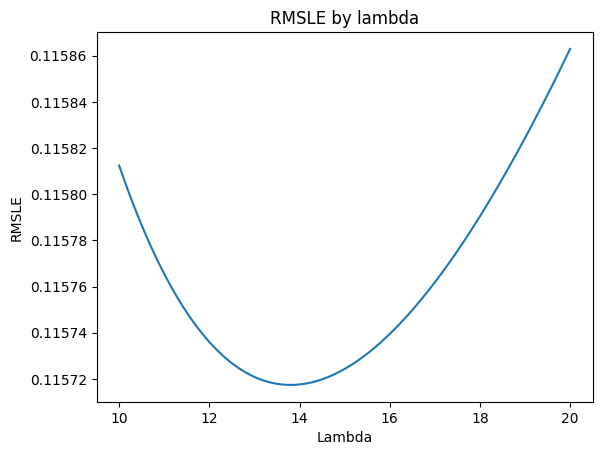

In [8]:
lambda_list = list(np.linspace(10, 20, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [9]:
ridge = Ridge(alpha = rmsle_ridge.idxmin())

### 1.1.2 Lasso

- Cũng tương tự với Ridge Regression, Lasso regression cũng là một loại của hồi quy tuyến tính
- Điểm khác biệt ở đây là, Regularization Term của Lasso regression khác với Ridge Regression.

- Regularization term trong Lasso regression là sẽ làm cho một số hệ số hồi quy sẽ được giảm về đúng bằng 0, tương đương với việc loại bỏ một số trọng số khỏi mô hình. Điều này giúp Lasso Regression phù hợp cho việc lựa chọn đặc trưng, vì nó có thể xác định những Feature quan trọng nhất để dự đoán kết quả cuối cùng.

- Lasso regression thường được sử dụng trong trường hợp có nhiều tham số và một số trong số chúng có thể không liên quan hoặc trùng lặp, lợi ích của nó là làm đơn giản hóa mô hình và tăng tính giải thích của nó.

#### Regularization Term = $λ * ||w||$
Trong đó: 
- $λ$ là hyperparameter
- $||w||$ độ lớn của các hệ số hồi quy


In [10]:
from sklearn.linear_model import Lasso

Như đã biết ở trên, Lasso Regression là một thuật toán tương tự Ridge Regression. Sự khác biệt ở đây là regularization term, thay vì dùng **sum of squared of $\theta$**, thì sử dụng **sum of absolute value of $\theta$**:

<a href="https://imgbb.com/"><img src="img/Loss_Lasso.png" alt="Loss_Lasso" border="0"></a>

Với phương pháp trên, chọn `lambda_` tốt nhất cho mô hình là  is **0.00058**.

<!-- ![Black box](https://github.com/hoangducnhatminh/predict-house-price-advanced/assets/94270107/60cec11c-2d25-4886-91fc-c4421efcd884) -->
<a href="https://github.com/hoangducnhatminh/predict-house-price-advanced/assets/94270107/60cec11c-2d25-4886-91fc-c4421efcd884"><img src="https://github.com/hoangducnhatminh/predict-house-price-advanced/assets/94270107/60cec11c-2d25-4886-91fc-c4421efcd884></img></a>
<!-- <img src=""> -->

Best lambda: 0.0005808080808080809
RMSLE: 0.11537177658532985


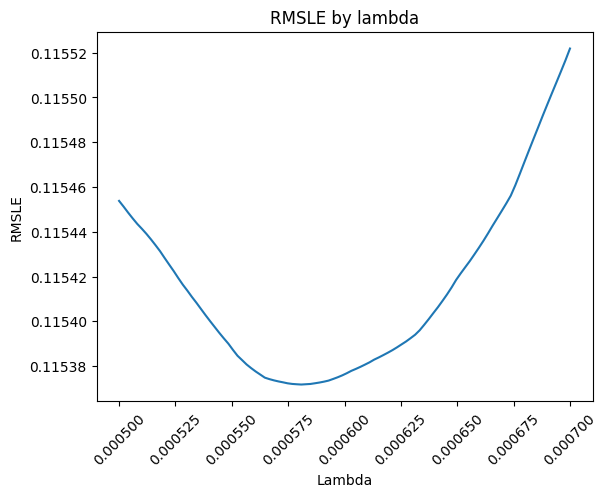

In [11]:
lambda_list = list(np.linspace(0.0005, 0.0007, 100))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=lambda_, max_iter=1000)) for lambda_ in lambda_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.xticks(rotation = 45)
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [12]:
lasso = Lasso(alpha = rmsle_lasso.idxmin(), max_iter=1000)

## 1.2 GRADIENT BOOSTING MODELS

### **GRADIENT BOOSTING**

- XGBRegressor là phiên bản cải tiến của Gradient Boosting nên chúng ta sẽ tìm hiểu sơ về Gradient Boosting trước.

- Boosting là kỹ thuật kết hợp nhiều model, mà model sau có thể học kinh nghiệm từ model trước.

<a href="https://imgbb.com/"><img src="img/Boosting.png" alt="Boosting" border="0"></a>

Trong Gradient Boosting các model sẽ là các Decision Tree.

Một ví dụ đơn giản cho cách hoạt động của Gradient Boosting:

<a href="https://ibb.co/HNRx9zz"><img src="img/GB_3.png" alt="GB_3" border="0"></a>

Sau nhiều lần lặp, thì Gradient Boosting sẽ có dạng như sau:

<a href="https://ibb.co/ryp29xy"><img src="img/GB_4.png" alt="GB_4" border="0"></a>

Thuật toán dừng đến khi cột cuối cùng cần dự đoán có số quá nhỏ, hoặc trong nhỏ hơn mức quy định.

### **BAYESIAN OPTIMIZATION**

[Tham khảo tại đây!](https://thetalog.com/thetaflow/bayesian-optimization-visualizer/)

#### *Giới thiệu*

- Tối ưu hóa (toán học) là ngành nghiên cứu tìm ra lời giải tối ưu (thỏa một số tiêu chí nhất định) từ tập lựa chọn cho trước. Tối ưu hóa giữ vai trò quan trọng trong nhiều ngành khác nhau, tùy theo ứng dụng của hệ thống mà sẽ có những độ đo liên quan, chúng ta mong muốn thiết kế những hệ thống vận hành một cách tốt nhất có thể, hay nói cách khác những độ đo liên quan (hiệu quả, an toàn và chính xác) phải ở trạng thái tối ưu.
- Một quá trình tối ưu hóa hệ thống có thể mô tả như sau:

<a href="https://ibb.co/nz4CYWK"><img src="img/progress_BO.png" alt="progress_BO" border="0"></a>

- Trong một số bài toán, chúng ta không hề biết công thức tổng quát của $f(x)$ (hoặc công thức tường minh quá phức tạp để có thể phân tích trực tiếp), lúc này chúng ta xem $f(x)$ như một hộp đen (black box function)

<a href="https://ibb.co/b3Pm2FG"><img src="img/Black_box.png" alt="Black_box" border="0"></a>

#### *Tình huống*
- Nếu f(x) là một hàm không quá phức tạp với thời gian tính toán thấp, chúng ta có thể tìm kiếm theo lưới (`grid search`) hoặc tìm kiếm ngẫu nhiên (`random search`).
- Tuy nhiên, đối với bài toán tối ưu trong trường hợp hàm số là hộp đen và có chi phí tính toán nặng nề thì `Bayesian Optimization` là một sự lựa chọn tốt nhất.

<a href="https://ibb.co/VthSKRr"><img src="img/Grid_search.png" alt="Grid_search" border="0"></a>

#### *Surrogate Model*

Nếu hàm số ${y} = f(x)$ có thể xây dựng mô hình thay thế, mô hình này cho phép mô tả một cách linh hoạt hàm cần tối ưu, đồng thời cho phép cho chúng ta khả năng ước lượng sự không chắc chắn về hàm số này.

<a href="https://ibb.co/x30txD7"><img src="img/Solution.png" alt="Solution" border="0"></a>

May mắn thay, nhiều phương pháp được xây dựng trên hướng tiếp cận thống kê Bayesian cho phép chúng ta xây dựng những mô hình như vậy! Một hàm tham thế, được xây dựng bởi niềm tin mà chúng ta tin vào dựa trên thông tin hiện có!

Giả sử có 4 điểm, một cách tự nhiên, càng xa những điểm đã biết thì sự không chắc chắc càng lớn dần, càng gần thì càng chắc chắn.

<a href="https://ibb.co/4jnB402"><img src="img/Surrogate_model.png" alt="Surrogate_model" border="0"></a>

#### *Mã giả*
Với hàm số cần tối ưu $f(x)$ xây dựng một mô hình hàm thay thế tương ứng `surrogate_model` cùng với hàm tiếp nhận $α(x)$ tương ứng, cùng với tập dữ liệu mà ta quan sát $D$ (sẽ được cập nhật theo thời gian)

<a href="https://ibb.co/S6PvQ77"><img src="img/Pseudo_Code.png" alt="Pseudo_Code" border="0"></a>

Khi thực hành, Bayesian Optimization hiệu quả nhất khi `surrogate_model` ước lượng tốt, hàm `acquisition_function` chọn hợp lí, chi phí tính toán của `surrogate_model` và `acquisition_function` phải nhỏ.

**Note:** Có thể demo cách chạy của Bayesian Optimization thông qua đường dẫn tham khảo !!

### 1.2.1 XGBRegressor

- Là thuật toán cải tiến từ Gradient Boosting, về cơ bản nó hoạt động như Gradient Boosting.
- Bên cạnh đó, nó còn bổ sung thêm Regularization để tránh Overfitting, khi xây dựng 1 cây quyết định nó sẽ tỉa những nhánh không tốt,...

Theo [hướng dẫn này](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) tham số cho thuật toán XGBoost, nhóm đã dùng thuật toán Bayesian Optimization để tìm các tham số tốt nhất:  `n_estimators`, `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`, `learning_rate`.

In [13]:
from xgboost import XGBRegressor

**Hyperparameter tuning sử dụng Bayesian Optimization**

In [18]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.randint('max_depth', 1, 5),
        'gamma': hp.uniform('gamma', 0, 1),
        'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.05, 0.1]),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' :  hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.randint('min_child_weight', 0, 10),
        'n_estimators': hp.randint('n_estimators', 1000, 2500)
    }

# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(params):
    
    xgboost = XGBRegressor(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

print('Best hyperparameters:', best)

100%|██████████| 100/100 [01:11<00:00,  1.40trial/s, best loss: 0.014405518716046764]
Best hyperparameters: {'colsample_bytree': np.float64(0.34616317741395974), 'gamma': np.float64(0.0017209909393271668), 'learning_rate': np.int64(3), 'max_depth': np.int64(1), 'min_child_weight': np.int64(5), 'n_estimators': np.int64(2455), 'reg_alpha': np.float64(0.6327967307254552), 'reg_lambda': np.float64(0.5602557190858286)}


In [19]:
lr = [0.001, 0.01, 0.05, 0.1]
best['learning_rate'] = lr[best['learning_rate']]

xgb = XGBRegressor(**best)
getRMSLE(xgb)

np.float64(0.11964976668067298)

Sau khi dùng Bayesian Optimization để tìm ra tham số tốt nhất cho `XGBRegressor`, nhóm chúng em chưa thực sự ưng ý với thông số này nên đã thêm một vài tham số mới và chỉnh tay (thử và sai) các thông số cũ, và nhận được kết quả khả quan hơn.

In [20]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=3,
                   min_child_weight=7,
                   gamma=0.00435,
                   subsample=0.65,
                   colsample_bytree=0.1761,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.41578,
                   reg_lambda=0.8678,
                   n_jobs=2)
getRMSLE(xgb)

np.float64(0.11854939080838263)

### 1.2.2 LGBMRegressor

LightGBM là một framork gradient boosting rất mạnh dựa trên thuật toán decision tree. 

Giống như XGBoost, LightGBM có kết quả tốt trên tập dữ liệu lớn và có tốc độ training nhanh hơn XGBoost nhiều. 

- Điểm tối ưu của lightgbm so với xgboost là ở 2 thuật toán: GOSS (Gradient Based One Side Sampling) và EFB (Exclusive Feature Bundling) giúp tăng tốc đáng kể trong quá trình tính toán. 

- Ngoài ra, LightGBM phát triển tree dựa trên leaf-wise, trong khi hầu hết các boosting tool khác (kể cả xgboost) dựa trên level-wise.

- Leaf-wise và Level-wise đều cho ra kết quả giống nhau khi xây dựng toàn bộ cây. Tuy nhiên, người ta ít khi xây dựng toàn bộ cây, mà sẽ quy định max_depth. Đối với, Leaf-wise lựa chọn nút để phát triển cây dựa trên tối ưu toàn bộ tree, trong khi level-wise tối ưu trên nhánh đang xét. Do đó, nó sẽ tốt hơn level-wise nếu xây dựng cùng 1 độ sâu.

- Note: Leaf-wise tuy tốt, nhưng với những bộ dữ liệu nhỏ, các tree xây dựng dựa trên leaf-wise thường dẫn đến overfit khá sớm. Do đó, lightgbm sử dụng thêm 1 hyperparameter là maxdepth nhằm cố gắng hạn chế điều này. Dù vậy, LightGBM vẫn được khuyến khích sử dụng khi bộ dữ liệu là đủ lớn.

Theo [hướng dẫn này](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), Nhóm đã tunning các tham số: `num_leaves`, `min_data_in_leaf`, `max_depth`, `bagging_fraction`, `feature_fraction`, `max_bin`. Theo như kết quả phía dưới, thì LightGBM cho kết quả tốt hơn XGBoost.

In [21]:
from lightgbm import LGBMRegressor

**Hyperparameter tuning sử dụng Bayesian Optimization**

In [22]:
space={'max_depth': hp.randint('max_depth', 1, 5),
        'learning_rate': hp.choice('learning_rate', [ 0.02, 0.05, 0.075, 1]),
        'num_leaves': hp.randint('num_leaves', 10, 50),
        'bagging_fraction':  hp.uniform('bagging_fraction', 0, 1),
        'bagging_freq':  hp.randint('bagging_freq', 0, 10),
        'n_estimators': hp.randint('n_estimators', 100, 1000),
        'max_bin': hp.randint('max_bin', 75, 300),
        'min_sum_hessian_in_leaf ': hp.randint('min_sum_hessian_in_leaf', 1, 50),
        'min_data_in_leaf': hp.randint('min_data_in_leaf', 0, 50),
        'feature_fraction_seed': hp.randint('feature_fraction_seed', 0, 8),
        'bagging_seed': hp.randint('bagging_seed', 0, 10)
    }

# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def objective(params):
    lgbm =  LGBMRegressor(objective='regression', seed=1, **params) 
    score = cross_val_score(estimator=lgbm, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=2).mean()
    
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=200, 
            trials=trials)

print('Best hyperparameters:', best)

100%|██████████| 200/200 [03:12<00:00,  1.04trial/s, best loss: 0.013895746077437798]
Best hyperparameters: {'bagging_fraction': np.float64(0.8411094440458349), 'bagging_freq': np.int64(1), 'bagging_seed': np.int64(7), 'feature_fraction_seed': np.int64(2), 'learning_rate': np.int64(2), 'max_bin': np.int64(130), 'max_depth': np.int64(2), 'min_data_in_leaf': np.int64(13), 'min_sum_hessian_in_leaf': np.int64(6), 'n_estimators': np.int64(860), 'num_leaves': np.int64(16)}


In [23]:
lr = [ 0.02, 0.05, 0.075, 1]
best['learning_rate'] = lr[best['learning_rate']]

xgb = XGBRegressor(**best)
getRMSLE(xgb)

np.float64(0.1244312182481468)

Sau khi dùng Bayesian Optimization để tìm ra tham số tốt nhất cho `LGBMRegressor`, nhóm chúng em chưa thực sự ưng ý với thông số này nên đã thêm một vài tham số mới và chỉnh tay (thử và sai) các thông số cũ, và nhận được kết quả khả quan hơn.

In [24]:
lgb = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=471,
                    num_leaves=10,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=120,
                    bagging_fraction=0.4586,
                    bagging_freq=1,
                    feature_fraction=0.24,
                    feature_fraction_seed=5,
                    bagging_seed=7,
                    min_sum_hessian_in_leaf=0)
getRMSLE(lgb)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

np.float64(0.1144178513898916)

## 1.3 ENSEMBLE MODELS

### 1.3.1 Bagging - Average Models

In [25]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])

        # Return average predictions
        return np.mean(predictions, axis=1)

In [26]:
avg_model = AveragingModel(models=(ridge, lasso, xgb, lgb))
getRMSLE(avg_model)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

np.float64(0.1118023088054676)

### 1.3.2 Stacking - Stack Average Models

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold

In [28]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [29]:
stacked_avg_models = StackingAveragedModels(base_models = (ridge, lasso, xgb, lgb),
                                            meta_model = ridge)
getRMSLE(stacked_avg_models)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

np.float64(0.11205954672400072)

# 2. Write submission

Ta thấy, mô hình kết hợp Bagging - Average models cho ra kết quả tốt nhất trong tất cả mô hình.

Do đó, ta sẽ dùng mô hình Bagging để dự đoán giá nhà của bộ dữ liệu test.

In [32]:
my_model = avg_model
my_model.fit(X_train, y)
y_pred = my_model.predict(test_data)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

In [33]:
predictions = np.exp(y_pred) - 1
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)